In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import time
import itertools
import math
import timeit
from decimal import Decimal
import warnings

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
import aesara
import aesara.tensor as at

In [4]:
from wolfram_grid import wolfram_dda, search_grid
from aesara_betainc import betainc
from aesara_incomplete_beta import incomplete_beta
from plot import plot_zlevel, plot_time

# Compile functions

## incomplete_beta

In [5]:
# Compile function
z = at.scalar('z')
a = at.scalar('a')
b = at.scalar('b')

out = incomplete_beta(a, b, z)
dda = aesara.grad(out, a)
ddb = aesara.grad(out, b)

In [6]:
start_compilation = time.time()
incomplete_beta_fn = aesara.function([z, a, b], out)
end_compilation = time.time()
print(end_compilation - start_compilation)

8.603840589523315


In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    start_compilation = time.time()
    incomplete_beta_der = aesara.function([z, a, b], [dda, ddb])
    end_compilation = time.time()
    print(end_compilation - start_compilation)

11.692783832550049


## betainc

In [8]:
# Compile function
z = at.scalar('z')
a = at.scalar('a')
b = at.scalar('b')

out = betainc(a, b, z)
dda = aesara.grad(out, a)
ddb = aesara.grad(out, b)

In [9]:
start_compilation = time.time()
betainc_fn = aesara.function([z, a, b], out)
end_compilation = time.time()
print(end_compilation - start_compilation)

0.00702977180480957


In [10]:
start_compilation = time.time()
betainc_der = aesara.function([z, a, b], [dda, ddb])
end_compilation = time.time()
print(end_compilation - start_compilation)

0.009758710861206055


# Op comparison

In [11]:
algos = dict(
    incomplete_beta = incomplete_beta_fn,
    betainc = betainc_fn
)

## Accuracy

In [12]:
a = 15
b = 1.25
z = 0.999

In [13]:
print(f'{"scipy".rjust(25)}: {sp.betainc(a, b, z)}')
for algo_name, algo in algos.items():
    print(f'{algo_name.rjust(25)}: {algo(z, a, b)}')

                    scipy: 0.9953553098163175
          incomplete_beta: 0.9953553098163175
                  betainc: 0.9953553098163175


In [14]:
def safe_division(xs, ys):
    result = []
    for x, y in zip(xs, ys):
        if y != 0:
            result.append(x / y)
        else:
            result.append(np.nan)
    return np.array(result)

def safe_log(xs):
    result = []
    for x in xs:
        if x != 0:
            result.append(math.log(x))
        else:
            result.append(np.NINF)
            
    return np.array(result)

In [15]:
df = pd.DataFrame(
    columns = ('z', 'a', 'b', 'scipy', *algos.keys())
)

for z, a, b in itertools.product(search_grid['z'], search_grid['a'], search_grid['b']):
    scipy_out = Decimal(sp.betainc(a, b, z))
    algos_out = [Decimal(float(algo(z, a, b))) for algo in algos.values()]
    df.loc[len(df)] = [z, a, b, scipy_out, *algos_out]

for algo_name in algos.keys():
    df[f'{algo_name}_abserr'] = np.abs(df['scipy'] - df[algo_name])
for algo_name in algos.keys():
    df[f'{algo_name}_relerr'] = np.abs(1 - safe_division(df[algo_name], df['scipy']))
for algo_name in algos.keys():
    df[f'{algo_name}_abserr_log'] = safe_log(df[f'{algo_name}_abserr'])
for algo_name in algos.keys():
    df[f'{algo_name}_relerr_log'] = safe_log(df[f'{algo_name}_relerr'])

In [16]:
df

,z,a,b,scipy,incomplete_beta,betainc,incomplete_beta_abserr,betainc_abserr,incomplete_beta_relerr,betainc_relerr,incomplete_beta_abserr_log,betainc_abserr_log,incomplete_beta_relerr_log,betainc_relerr_log
0,0.001,1.5,1.25,0.00004220468445403043121315345143074182487907...,0.00004220468445403047187073491963715810015855...,0.00004220468445403043121315345143074182487907...,4.065758146820641627527948003E-20,0E-65,9.63342860968E-16,0,-44.649102,-inf,-34.576122,-inf
1,0.001,1.5,12.50,0.00107504003906712082908048166984826821135357...,0.00107504003906711822699526770463762659346684...,0.00107504003906712082908048166984826821135357...,2.602085213965210641617886722E-18,0E-61,2.4204542337076E-15,0,-40.490219,-inf,-33.654821,-inf
2,0.001,1.5,125.00,0.03096957254214988478069336963471869239583611...,0.03096957254215050581169776933165849186480045...,0.03096957254214988478069336963471869239583611...,6.210310043996969397994689643E-16,0E-58,2.0052940787428E-14,0,-35.015151,-inf,-31.540401,-inf
3,0.001,1.5,1250.00,0.52502527105824847719617309849127195775508880...,0.52502527105917362604259324143640697002410888...,0.52502527105824847719617309849127195775508880...,9.251488464201429451350122690E-13,0E-53,1.762103459430438E-12,0,-27.708822,-inf,-27.064513,-inf
4,0.001,1.5,12500.00,0.99998465590068053021610694486298598349094390...,0.99998465589237306438974428601795807480812072...,0.99998465590068053021610694486298598349094390...,8.307465826362658845027908683E-12,0E-53,8.3075932988993429E-12,0,-25.513867,-inf,-25.513851,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0.999,15000.0,1.25,6.69700434652111721132332951972321311018276901...,6.69700434648062268369746955626320428223152703...,6.69700434652111721132332951972321311018276901...,4.049452762585996346000882795E-18,0E-73,6.0466628854579727E-12,0,-40.047950,-inf,-25.831515,-inf
121,0.999,15000.0,12.50,0.22329776078335192290857946773030562326312065...,0.22329776078339255707128074845968512818217277...,0.22329776078335192290857946773030562326312065...,4.063416270128072937950491905E-14,0E-55,1.81972996767777E-13,0,-30.834167,-inf,-29.334918,-inf
122,0.999,15000.0,125.00,0.99999999999999988897769753748434595763683319...,0.99999999999999977795539507496869191527366638...,0.99999999999999988897769753748434595763683319...,1.110223024625156540423631668E-16,0E-53,1.110223024625E-16,0,-36.736801,-inf,-36.736801,-inf
123,0.999,15000.0,1250.00,0.99999999999999988897769753748434595763683319...,0.99999999999999977795539507496869191527366638...,0.99999999999999988897769753748434595763683319...,1.110223024625156540423631668E-16,0E-53,1.110223024625E-16,0,-36.736801,-inf,-36.736801,-inf


In [17]:
for z in search_grid['z']:
    lnvalues = df.loc[df['z']==z, 'incomplete_beta_abserr_log':'betainc_abserr_log'].values
    flnvalues = lnvalues[np.isfinite(lnvalues)]
    print(z, np.min(flnvalues), np.max(flnvalues))

0.001 -591.9124325197104 -25.513866508279
0.25 -576.3521601253681 -9.540664656824442
0.5 -719.8728955664883 -30.361775749849006
0.75 -458.0432149876191 -36.04365338911715
0.999 -40.04794992225309 -30.460157080335456


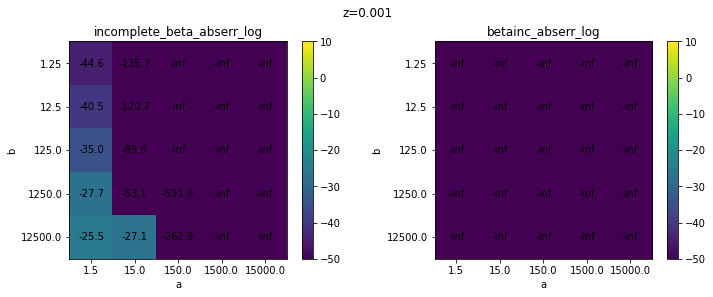

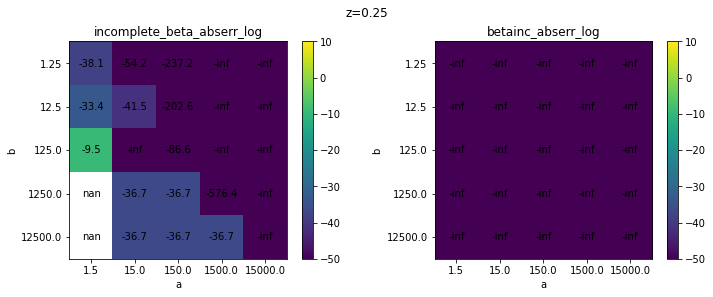

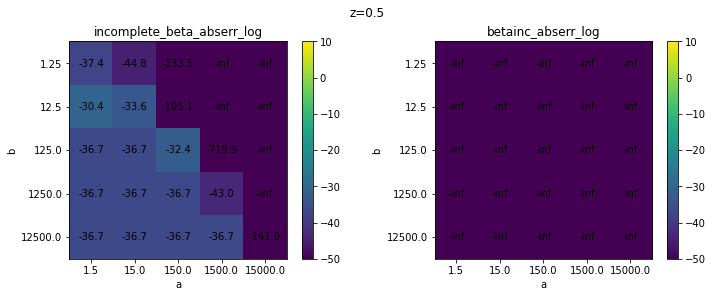

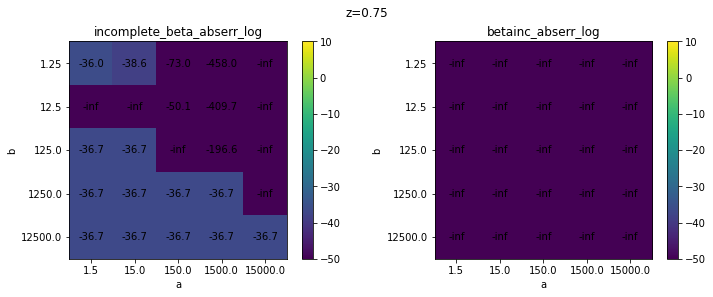

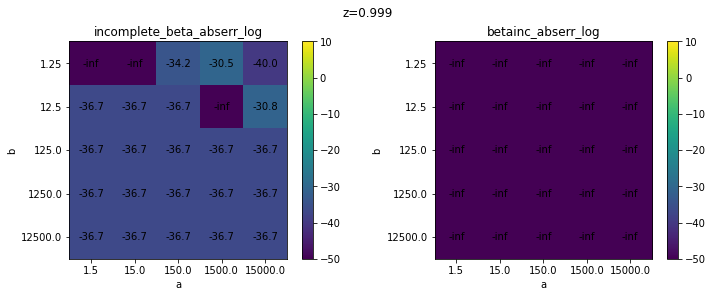

In [18]:
for z in search_grid['z']:
    tdf = df[df['z']==z][[
        'z', 'a', 'b', 
        'incomplete_beta_abserr_log', 
        'betainc_abserr_log',
    ]]
    plot_zlevel(tdf, vmin=-50, vmax=10)

In [19]:
for z in search_grid['z']:
    lnvalues = df.loc[df['z']==z, 'incomplete_beta_relerr_log':'betainc_relerr_log'].values
    flnvalues = lnvalues[np.isfinite(lnvalues)]
    print(z, np.min(flnvalues), np.max(flnvalues))

0.001 -34.57612229122516 -25.180353309708888
0.25 -36.73680056967724 -9.54066465682444
0.5 -36.73680056967724 -24.46779293335161
0.75 -36.73680056967724 -27.665306015564415
0.999 -36.73680056967724 -25.831514585247575


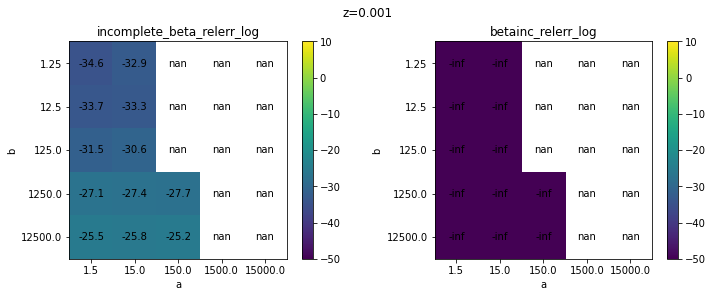

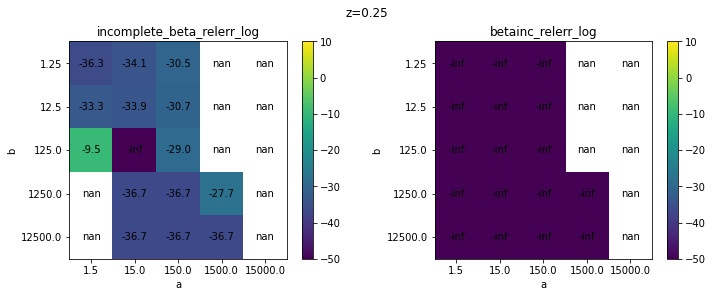

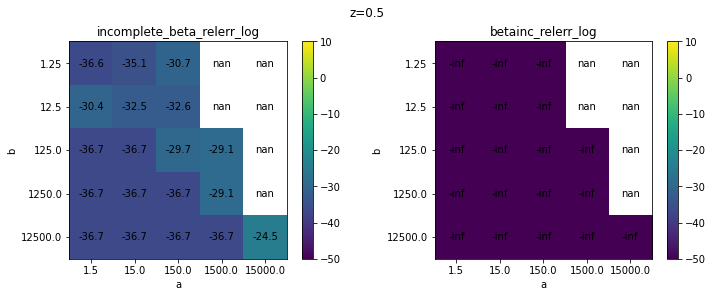

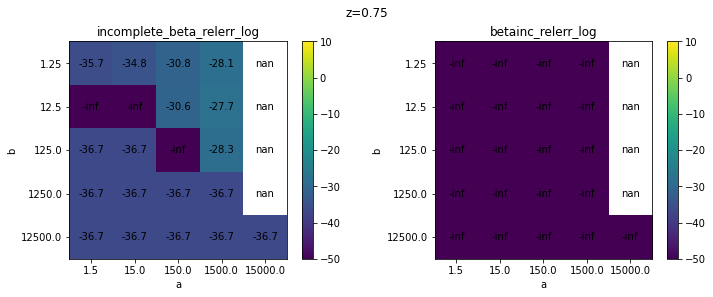

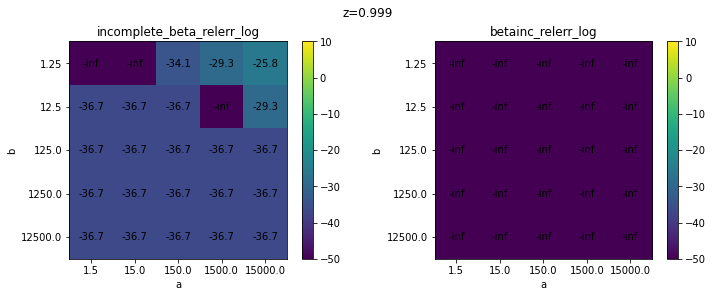

In [20]:
for z in search_grid['z']:
    tdf = df[df['z']==z][[
        'z', 'a', 'b', 
        'incomplete_beta_relerr_log', 
        'betainc_relerr_log',
    ]]
    plot_zlevel(tdf, vmin=-50, vmax=10)

## Speed

In [21]:
tdf = pd.DataFrame(
    columns = ('z', 'a', 'b', *algos.keys())
)

for i, (z, a, b) in enumerate(itertools.product(search_grid['z'], search_grid['a'], search_grid['b'])):
    if i % 5 == 0:
        print(i)

    algos_avg_time = []
    for j, algo in enumerate(algos.values()):
        algo_avg_time = timeit.timeit(lambda: algo(z, a, b), number=100) / 100
        algos_avg_time.append(algo_avg_time)
    
    tdf.loc[len(tdf)] = [z, a, b, *algos_avg_time]

for algo_name in algos.keys():
    tdf[f'{algo_name}_log'] = np.log(tdf[algo_name])

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120


In [22]:
tdf

,z,a,b,incomplete_beta,betainc,incomplete_beta_log,betainc_log
0,0.001,1.5,1.25,0.000300,0.000036,-8.111733,-10.238340
1,0.001,1.5,12.50,0.000329,0.000035,-8.018637,-10.246478
2,0.001,1.5,125.00,0.000452,0.000056,-7.701202,-9.788890
3,0.001,1.5,1250.00,0.000567,0.000050,-7.475330,-9.908997
4,0.001,1.5,12500.00,0.002664,0.000053,-5.927810,-9.843398
...,...,...,...,...,...,...,...
120,0.999,15000.0,1.25,0.004473,0.000065,-5.409679,-9.643788
121,0.999,15000.0,12.50,0.002469,0.000056,-6.003750,-9.794189
122,0.999,15000.0,125.00,0.001825,0.000065,-6.306409,-9.646433
123,0.999,15000.0,1250.00,0.003464,0.000064,-5.665208,-9.663282


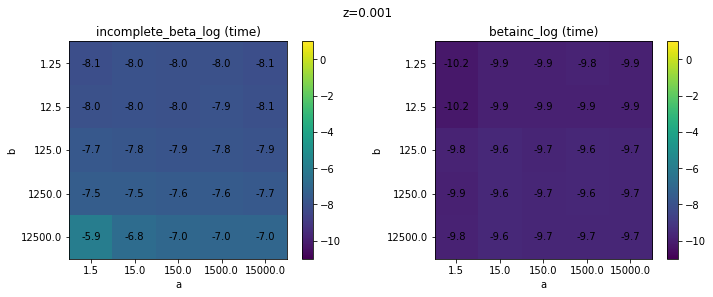

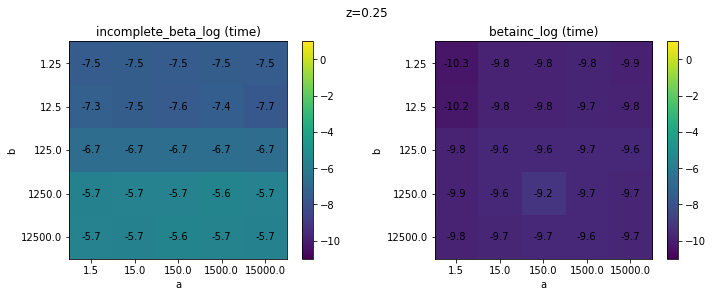

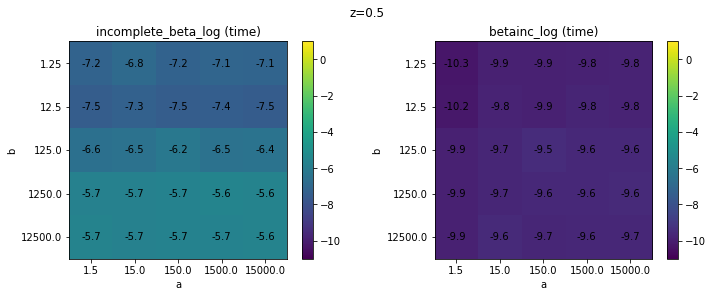

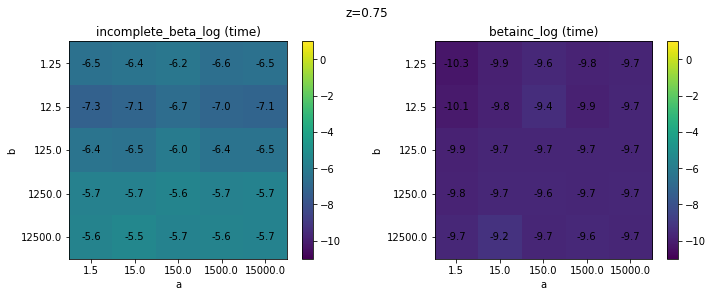

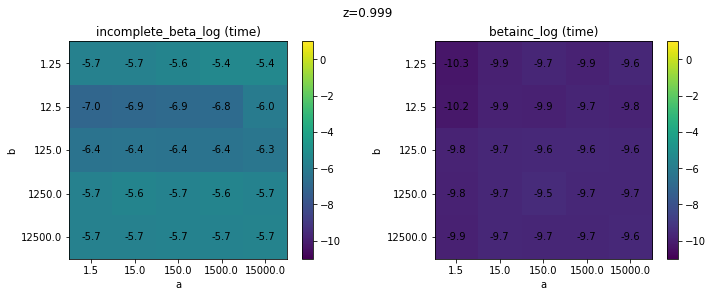

In [23]:
for z in search_grid['z']:
    ttdf = tdf[tdf['z']==z][[
        'z', 'a', 'b', 
        'incomplete_beta_log', 
        'betainc_log',
    ]]
    plot_time(ttdf, -11, 1)

# Derivative comparison

In [24]:
algos = dict(
    incomplete_beta = incomplete_beta_der,
    betainc = betainc_der
)

## Accuracy

In [25]:
a = 15
b = 1.25
z = 0.999

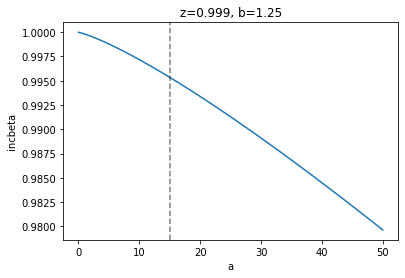

In [26]:
x = np.linspace(0, 50, 10000)
y = sp.betainc(x, b, z)
plt.plot(x, y)
plt.axvline(a, c='k', ls='dashed', alpha=.5)
plt.ylabel('incbeta')
plt.xlabel('a')
plt.title(f'{z=}, {b=}');

In [27]:
print(f'{"wolfram".rjust(25)}: {wolfram_dda(z, a, b)}')
for algo_name, algo in algos.items():
    print(f'{algo_name.rjust(25)}: {algo(z, a, b)[0]}')

                  wolfram: -0.0003813609775934895
          incomplete_beta: -0.0003813609775976195
                  betainc: -0.0003813609775940947


In [28]:
df = pd.DataFrame(
    columns = ('z', 'a', 'b', 'wolfram', *algos.keys())
)

for z, a, b in itertools.product(search_grid['z'], search_grid['a'], search_grid['b']):
    w_dda = Decimal(wolfram_dda(z, a, b))
    algos_dda = [Decimal(float(algo(z, a, b)[0])) for algo in algos.values()]
    df.loc[len(df)] = [z, a, b, w_dda, *algos_dda]

for algo_name in algos.keys():
    df[f'{algo_name}_abserr'] = np.abs(df['wolfram'] - df[algo_name])
for algo_name in algos.keys():
    df[f'{algo_name}_relerr'] = np.abs(1 - safe_division(df[algo_name], df['wolfram']))
for algo_name in algos.keys():
    df[f'{algo_name}_abserr_log'] = safe_log(df[f'{algo_name}_abserr'])
for algo_name in algos.keys():
    df[f'{algo_name}_relerr_log'] = safe_log(df[f'{algo_name}_relerr'])

In [29]:
df

,z,a,b,wolfram,incomplete_beta,betainc,incomplete_beta_abserr,betainc_abserr,incomplete_beta_relerr,betainc_relerr,incomplete_beta_abserr_log,betainc_abserr_log,incomplete_beta_relerr_log,betainc_relerr_log
0,0.001,1.5,1.25,-0.0002866563657042640054020687934155375842237...,-0.0002866563658944571899543640736141014713211...,-0.0002866563657042642764526119147916460860869...,1.901931845522952801985638871E-13,2.710505431213761085018632002E-19,6.63488438796829977E-10,9.45559127757E-16,-29.290736,-42.751982,-21.133510,-34.594755
1,0.001,1.5,12.50,-0.0053857750078742730459602228165749693289399...,-0.0053857718512460824381027357787843357073143...,-0.0053857750078742877911097686194352718302980...,3.156628190607857487037790634E-9,1.474514954580286030250135809E-17,5.861047269877981967698E-7,2.737795307870E-15,-19.573761,-38.755617,-14.349767,-33.531623
2,0.001,1.5,125.00,-0.0865505603779457982627221213078883010894060...,-0.0865385081223506297254388641704281326383352...,-0.0865505603779557347587925164589250925928354...,0.00001205225559516853728325713746,9.936496070395151036791503429E-15,0.0001392510405771977858189873,1.14805681523087E-13,-11.326259,-32.242562,-8.879232,-29.795535
3,0.001,1.5,1250.00,-0.3670055021667202876933799871039809659123420...,-0.3670055020888858821059841375245014205574989...,-0.3670055021665507011263684944424312561750411...,7.783440558739584957947954535E-11,1.695865670114926615497097373E-13,2.120796694542139754E-10,4.620818107910934E-13,-23.276438,-29.405413,-22.274059,-28.403034
4,0.001,1.5,12500.00,-0.0000393756276793055803864262998104095458984375,36.9331700739394790389269473962485790252685546875,-0.0000393756371992461684538623656326450372944...,36.93320944956715834450733382,9.519940588067436065822235491E-12,937971.3194763351141510312081,2.41772414794311351856E-7,3.609111,-25.377633,13.751475,-15.235269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0.999,15000.0,1.25,-6.1422760376990657589152725580328162635623812...,-6.5954322570175477533074450379882783246365818...,-6.5954322570614482963671655992628911624464649...,4.531562193184819943921724800E-11,4.531562193623825374518930412E-11,0.073776596254738999145565054,0.073776596261886275300246955,-23.817369,-23.817369,-2.606714,-2.606714
121,0.999,15000.0,12.50,-0.0000373993100414921801968870518351195642026...,-0.0000746930863231316241124604915491147494321...,-0.0000746930863231799795293533450468714818271...,0.00003729377628163944391557343971,0.00003729377628168779933246629321,0.997178189658160719592725715,0.997178189659453669030541712,-10.196684,-10.196684,-0.002826,-0.002826
122,0.999,15000.0,125.00,0.00729857796930133417845354415476322174072265625,0,-2.3012804920116062996921340167543054501061374...,0.007298577969301334178453544155,0.007298577969301334178453544155,1,1.000000000000000000000000000,-4.920076,-4.920076,0.000000,0.000000
123,0.999,15000.0,1250.00,0.07904477149730482210543414112180471420288085...,0,-0,0.07904477149730482210543414112,0.07904477149730482210543414112,1,1,-2.537741,-2.537741,0.000000,0.000000


In [30]:
for z in search_grid['z']:
    lnvalues = df.loc[df['z']==z, 'incomplete_beta_abserr_log':'betainc_abserr_log'].values
    flnvalues = lnvalues[np.isfinite(lnvalues)]
    print(z, np.min(flnvalues), np.max(flnvalues))

0.001 -569.1887736947223 3.6091111313858515
0.25 -555.6153390412865 497.253901682031
0.5 -697.9880283364658 40.68988186507227
0.75 -437.25522530173436 165.924433261865
0.999 -35.941949452948876 86.36885524378881


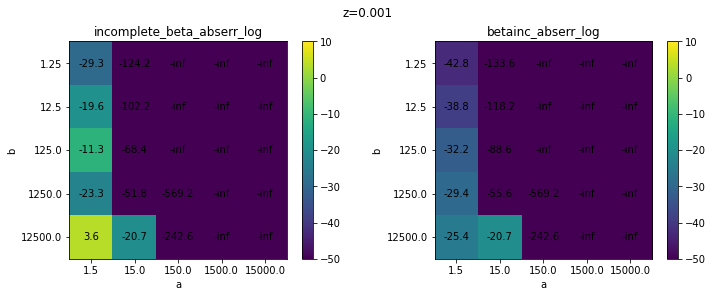

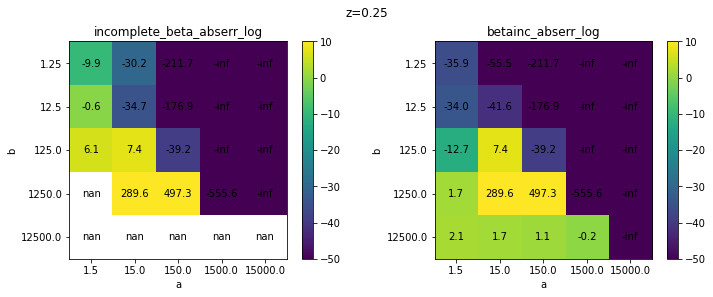

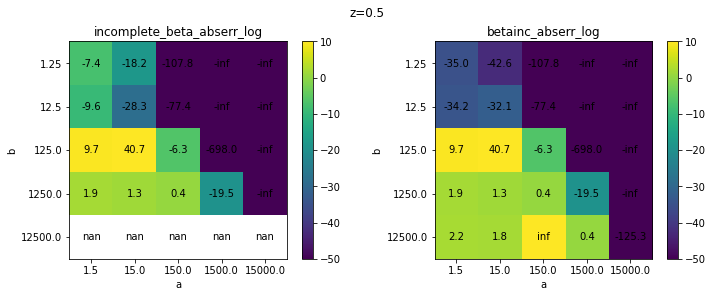

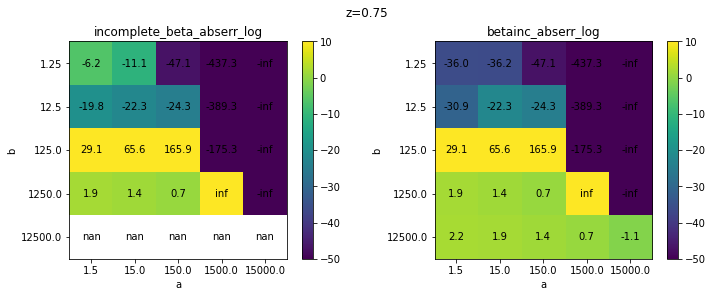

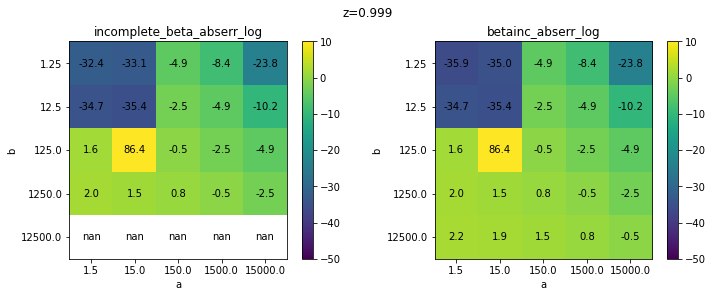

In [31]:
for z in search_grid['z']:
    tdf = df[df['z']==z][[
        'z', 'a', 'b', 
        'incomplete_beta_abserr_log', 
        'betainc_abserr_log',
    ]]
    plot_zlevel(tdf, vmin=-50, vmax=10)

In [32]:
for z in search_grid['z']:
    lnvalues = df.loc[df['z']==z, 'incomplete_beta_relerr_log':'betainc_relerr_log'].values
    flnvalues = lnvalues[np.isfinite(lnvalues)]
    print(z, np.min(flnvalues), np.max(flnvalues))

0.001 -34.59475525178239 13.751474651269657
0.25 -35.69134852060891 18.722613111124062
0.5 -33.68646595191237 0.0
0.75 -34.24887017242389 0.0
0.999 -27.532017138004445 1.4653777382511193


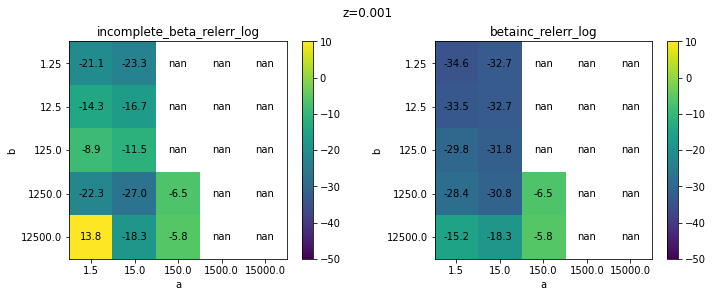

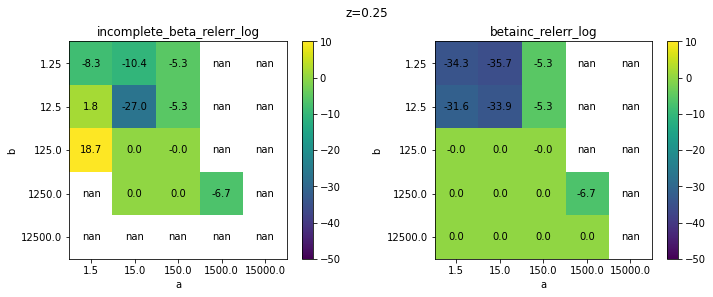

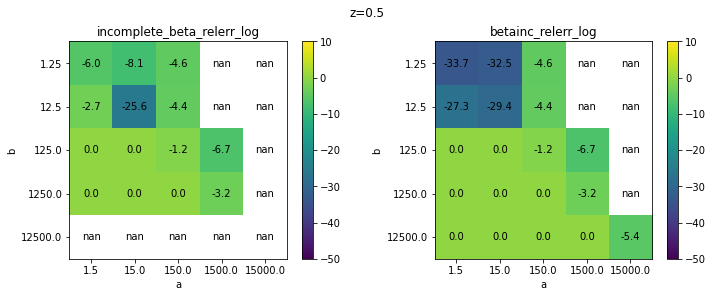

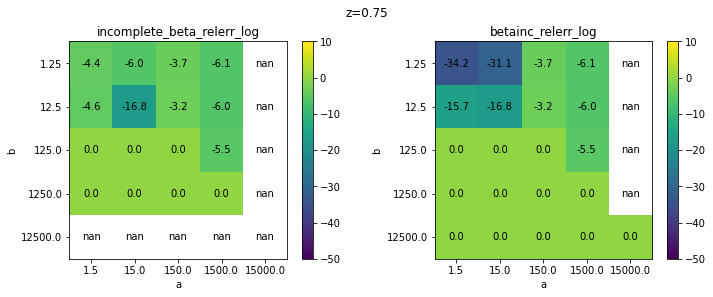

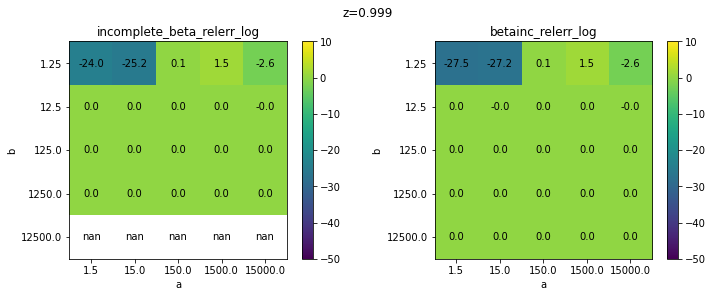

In [33]:
for z in search_grid['z']:
    tdf = df[df['z']==z][[
        'z', 'a', 'b', 
        'incomplete_beta_relerr_log', 
        'betainc_relerr_log',
    ]]
    plot_zlevel(tdf, vmin=-50, vmax=10)

## Speed

In [34]:
tdf = pd.DataFrame(
    columns = ('z', 'a', 'b', *algos.keys())
)

for i, (z, a, b) in enumerate(itertools.product(search_grid['z'], search_grid['a'], search_grid['b'])):
    if i % 5 == 0:
        print(i)

    algos_avg_time = []
    for j, algo in enumerate(algos.values()):
        algo_avg_time = timeit.timeit(lambda: algo(z, a, b), number=100) / 100
        algos_avg_time.append(algo_avg_time)
    
    tdf.loc[len(tdf)] = [z, a, b, *algos_avg_time]

for algo_name in algos.keys():
    tdf[f'{algo_name}_log'] = np.log(tdf[algo_name])

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120


In [35]:
tdf

,z,a,b,incomplete_beta,betainc,incomplete_beta_log,betainc_log
0,0.001,1.5,1.25,0.002073,0.000138,-6.178696,-8.888331
1,0.001,1.5,12.50,0.002158,0.000138,-6.138386,-8.891167
2,0.001,1.5,125.00,0.002553,0.000179,-5.970399,-8.625639
3,0.001,1.5,1250.00,0.003423,0.000209,-5.677188,-8.475289
4,0.001,1.5,12500.00,0.015655,0.000283,-4.156943,-8.168540
...,...,...,...,...,...,...,...
120,0.999,15000.0,1.25,0.020862,0.000213,-3.869832,-8.453068
121,0.999,15000.0,12.50,0.009961,0.000271,-4.609044,-8.215014
122,0.999,15000.0,125.00,0.007516,0.000144,-4.890755,-8.842307
123,0.999,15000.0,1250.00,0.015327,0.000155,-4.178169,-8.775136


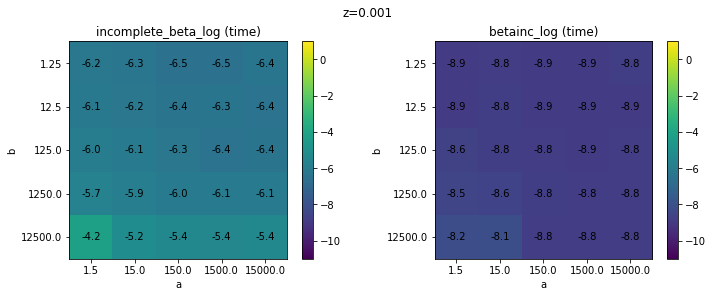

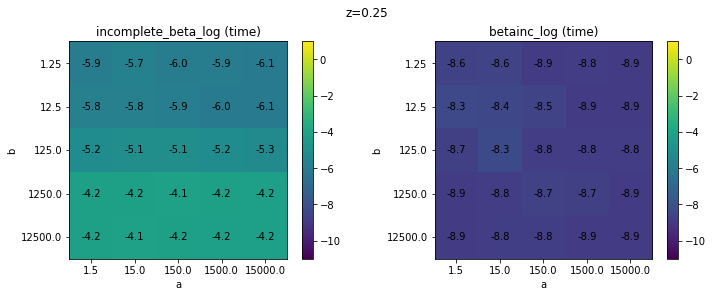

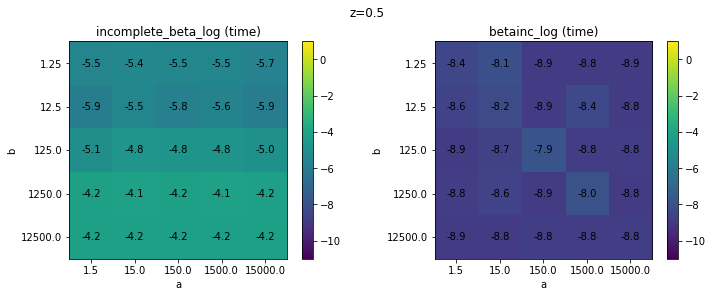

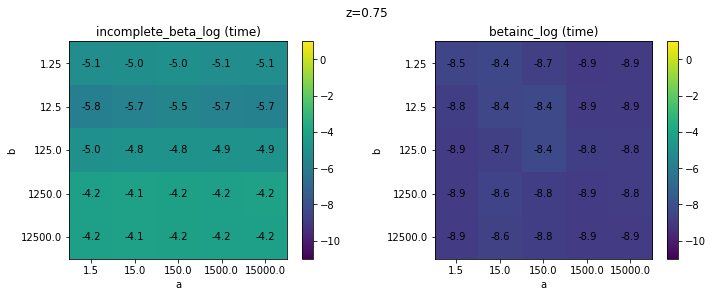

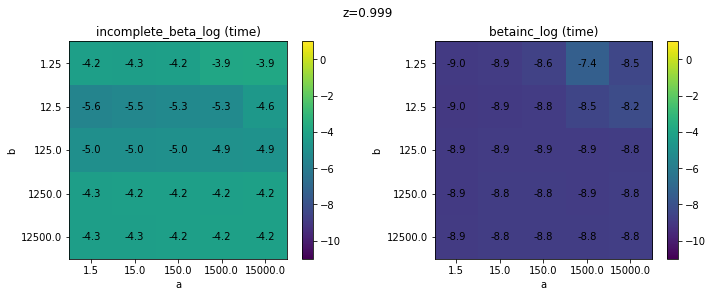

In [36]:
for z in search_grid['z']:
    ttdf = tdf[tdf['z']==z][[
        'z', 'a', 'b', 
        'incomplete_beta_log', 
        'betainc_log',
    ]]
    plot_time(ttdf, -11, 1)